In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import imblearn
import scipy
import seaborn as sns

Do klasyfikacji trending/non-trending zostaną wykorzystane dane zunifikowane w dokładnie taki sam sposób jak w części 5. (te, które z różnych przyczyn występują tylko w jednym ze zbiorów, zostaną pominięte), a dane o nietypowym rozkładzie bądź niemające charakteru rzeczywistoliczbowego zostaną przetworzone jak w ćwiczeniu 4 (przetworzenie atrybutów kategorycznych do postaci one-hot-encoding oraz niektórych zmiennych na ich kwantyle).

Podobnie jak w problemie klasyfikacji, wszystkie dostępne dane tekstowe zostaną wspólnie stokenizowane, jednak ich wykorzystanie wydaje się wątpliwe - ze względu na mniejszą wartość "oceny" pojedynczego słowa z perspektywy użycia przez aspirującego youtubera, nie jest to pożądana cecha. Ze względu na problem rzadkości danych i mnogość słów, zaobserwowane mogłyby zostać korelacje, które powstały przypadkowo, a które tylko zaszumiałyby ogólny obraz. Jednakże, choć cechy związane z wystąpieniem konkretnych słów zdają się więcej mówić o kategorii filmu niż jego obecności w zakładce trending, niektóre z nich mogą być z nią skorelowane (np. w przypadku filmów dotyczących szachów "przepisem na sukces" jest podobno umieszczenie w tytule nazwiska mistrza świata w tej grze, Magnusa Carlsena). Być może ciekawymi i mniej zaszumionymi obserwacjami zaowocuje wykorzystanie tylko bardzo niewielkiej liczby najpopularniejszych tokenów.

In [2]:
def read_csv(title):
    df = pd.read_csv(title)
    df = df.iloc[:, 2:].reset_index()
    return df

In [3]:
trending = read_csv('sigma.csv')[:500]
non_trending = read_csv('pi.csv')
print(trending.shape, non_trending.shape)
pd.set_option("display.max_columns", None)

columns = list(trending)
[columns.remove(c) for c in set(list(trending))-set(list(non_trending))]
trending = trending[columns]
non_trending = non_trending[columns]

trending['label'] = 1
non_trending['label'] = 0

df = pd.concat([trending, non_trending], ignore_index=True)

(500, 33) (329, 35)


In [4]:
trending.head()

,index,video_id,title,channelTitle,tags,thumbnail_link,description,title_length,description_length,nr_tags,interpunction_exclamation,interpunction_dot,interpunction_comma,publishedAt_modern,weekday_published,action_canny,new_category,definition,duration_s,amount_faces,emotion,writing_thumbnail,big_letters_thumbnail,licensed_content,caption_,color_1,color_2,color_3,screamy_1,label
0,0,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,jacksepticeye,jacksepticeye|funny|funny meme|memes|jacksepti...,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,I left youtube for a month and this is what ha...,53.0,513.0,30.0,0.0,1.0,0.0,2020-08-11 16:34:06,1.0,0.180833,24.0,hd,1330.0,0.0,NaN,fe,0.0,1,0,-0.183822,0.605972,1.342097,-0.949221,1
1,1,xTpr7piQu2M,FUT 21 | Official Trailer,EA SPORTS FIFA,Fifa|fifa 21|fifa21|fifa 21 trailer|fifa 21 ne...,https://i.ytimg.com/vi/xTpr7piQu2M/default.jpg,"Play with friends, customise your stadium, and...",25.0,844.0,27.0,0.0,0.0,0.0,2020-08-10 15:00:08,0.0,0.203519,20.0,hd,219.0,2.0,sad,a|OFFICIAL ||TRAILER|,15.0,1,1,-0.285196,0.254104,0.601744,-0.561858,1
2,2,8QsH_xPQFqM,ALREADY | Black Is King | Aliya Janell | Kany ...,Aliya Janell,Aliya Janell|Aliya Janell choreography|queens ...,https://i.ytimg.com/vi/8QsH_xPQFqM/default.jpg,Had the pleasure of learning from this queen n...,84.0,793.0,4.0,0.0,0.0,0.0,2020-08-10 19:00:10,0.0,0.127222,24.0,hd,118.0,0.0,NaN,Ma,1.0,0,0,2.019191,-0.163342,-0.666444,0.368227,1
3,3,jp47GeO6k6Q,How Does He Get Away With This?,JxmyHighroller,LeBron James|LA Lakers|House of Highlights|ESP...,https://i.ytimg.com/vi/jp47GeO6k6Q/default.jpg,?GET YOUR EXCLUSIVE BASKETBALL SHORTS NOW! htt...,31.0,975.0,28.0,0.0,0.0,0.0,2020-08-09 18:42:25,6.0,0.173241,17.0,hd,852.0,NaN,NaN,NaN,NaN,1,0,0.244271,-0.367318,-1.704233,-0.332215,1
4,4,PHYtv0v2DeA,NUGGETS at LAKERS | FULL GAME HIGHLIGHTS | Aug...,NBA,NBA|G League|Basketball|game-0021901296|Jump S...,https://i.ytimg.com/vi/PHYtv0v2DeA/default.jpg,NUGGETS at LAKERS | FULL GAME HIGHLIGHTS | Aug...,58.0,746.0,27.0,0.0,0.0,1.0,2020-08-11 03:53:08,1.0,0.206204,17.0,hd,584.0,2.0,happy,|Wish|AKERS,6.0,1,0,-1.614996,-0.816781,0.670144,2.550544,1


In [5]:
non_trending.head()

,index,video_id,title,channelTitle,tags,thumbnail_link,description,title_length,description_length,nr_tags,interpunction_exclamation,interpunction_dot,interpunction_comma,publishedAt_modern,weekday_published,action_canny,new_category,definition,duration_s,amount_faces,emotion,writing_thumbnail,big_letters_thumbnail,licensed_content,caption_,color_1,color_2,color_3,screamy_1,label
0,0,-5q5mZbe3V8,BTS (방탄소년단) 'Life Goes On' Official MV,HYBE LABELS,"['BIGHIT', '빅히트', '방탄소년단', 'BTS', 'BANGTAN', '...",https://i.ytimg.com/vi/-5q5mZbe3V8/sddefault.j...,BTS (방탄소년단) 'Life Goes On' Official MV\n\n\nCr...,38,1426,1,0,0,0,2020-11-19,3,0.139444,10,hd,231,1.0,neutral,NaN,0.0,1,1,3.247967,0.139233,1.679608,-0.120556,0
1,1,-EjsCBHEbbk,ZOMBIE GIRL ESCAPE PREGNANCY PRANK BATTLE - Do...,Sky Nerf War,"['Sky Nerf War', 'skynerfwar', 'ZOMBIE GIRL', ...",https://i.ytimg.com/vi/-EjsCBHEbbk/sddefault.jpg,ZOMBIE GIRL ESCAPE PREGNANCY PRANK BATTLE - Do...,96,589,1,0,0,0,2020-11-28,5,0.228148,24,hd,337,2.0,happy,| | | | |,0.0,1,0,-2.088426,1.017492,0.006638,3.174299,0
2,2,-IkMlsfh-JM,Kaczor BRS ft. John Mojo - To my,Prima Sort,"['Kaczor BRS', 'John Mojo', 'To my', 'Wróg pub...",https://i.ytimg.com/vi/-IkMlsfh-JM/sddefault.j...,To już ostatni singiel Kaczora BRS promujący w...,32,1576,1,0,1,0,2020-08-19,2,0.117222,10,hd,146,0.0,NaN,,0.0,1,0,1.735375,7.204247,-0.050060,-0.323712,0
3,3,-JCHUr2l2MY,If My Boyfriend Was a Superhero,Troom Troom,"['if my boyfriend was a superhero', 'after mov...",https://i.ytimg.com/vi/-JCHUr2l2MY/sddefault.jpg,Subscribe Here: https://www.youtube.com/channe...,31,2665,1,0,0,0,2020-09-18,4,0.149444,26,hd,698,1.0,surprise,SS|| | |c=|Lm SW| |ay,5.0,1,0,-2.391273,-0.166170,-0.495372,-0.678857,0
4,4,-h__d82x3lI,[♥ Kids Room(하트키즈룸)] Ep.02 I.N,Stray Kids,"['Stray Kids', '스트레이 키즈', 'SKZ', '스키즈', '방찬', ...",https://i.ytimg.com/vi/-h__d82x3lI/sddefault.jpg,[♥ Kids Room(하트키즈룸)] Ep.02 아이엔(I.N)\n\nStray K...,30,638,1,0,2,0,2020-09-23,2,0.155833,22,hd,611,NaN,NaN,NaN,NaN,1,1,-3.396324,-0.091572,-0.052493,-0.658100,0


Powtórzone z poprzednich etapów techniki preprocessingu:

In [6]:
column_names = []

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

hyperlink_stopwords = ['www', 'http', 'https' ,'com', 'bit', 'ly', 'youtu', 'youtube']
stopwords = stopwords.words('english') + hyperlink_stopwords

vec = CountVectorizer(max_features=30, stop_words=stopwords)
df['texts'] = df['tags'].fillna('') + df['description'].fillna('') + df ['channelTitle'].fillna('')



bag_of_words = vec.fit_transform(df['description'].fillna(''))
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:10]

for token in vec.get_feature_names_out():
    column_names.append('Word count: '+ token)
    
print(len(column_names))

30


In [8]:
from sklearn.preprocessing import OneHotEncoder

emotions=df['emotion'].unique()
print(emotions)

def emotion_to_int(e):
    if np.argwhere(emotions==e).size == 1:
        return int(np.argwhere(emotions==e))
    else:
        return 0

ohe = OneHotEncoder()

int_emotions = [emotion_to_int(e) for e in df['emotion']]


onehot_emotions = ohe.fit_transform(np.array(int_emotions).reshape(-1, 1))
onehot_emotions = onehot_emotions[:, 1:]

for e in emotions[1:]:
    column_names.append('Emotion: ' + e)
    
    
print(len(column_names))

[nan 'sad' 'happy' 'neutral' 'angry' 'surprise' 'fear' 'disgust']
37


In [9]:
from sklearn.preprocessing import QuantileTransformer

quantile_features = ['title_length', 'description_length', 'interpunction_exclamation', #'nr_tags',
                     'interpunction_dot', 'interpunction_comma', 'action_canny', 'duration_s',
                     'amount_faces', 'big_letters_thumbnail', 'licensed_content', 'caption_', 
                     'color_1', 'color_2', 'color_3', 'screamy_1']

quantile_attributes = df[quantile_features]
q = QuantileTransformer()
q_att = q.fit_transform(np.array(quantile_attributes.fillna(quantile_attributes.mean().to_dict())))
print(q_att.shape)

for q in quantile_features:
    column_names.append(q)
    


(829, 15)


c:\users\grzegorz\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (829). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)


In [10]:
print(bag_of_words.shape, onehot_emotions.shape, q_att.shape, len(column_names))

(829, 30) (829, 7) (829, 15) 52


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


X = scipy.sparse.hstack((bag_of_words.astype('bool').astype('float'), onehot_emotions.astype('float'), q_att)).toarray()
Xdf = pd.DataFrame(data = X, 
                  columns = column_names)

Xdf.head()
y = df['label']

Xtrain, Xtest, ytrain, ytest = train_test_split(Xdf, y, train_size=0.4, stratify=y)

Celem zadania jest przede wszystkim stworzenie interpretowalnego modelu, którego analiza pozwoli na wyznaczenie kluczowych parametrów zwiększających szanse filmu na dostanie się do zakładki do trending. Wykorzystane zostaną dwa klasyfikatory, które to umożliwiają: prostszym z nich będzie regresja logistyczna, a bardziej zaawansowanym - las losowy.

In [12]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(Xtrain, ytrain)

pred = rfc.predict(Xtest)
print('Accuracy:, ', accuracy_score(ytest, pred), ', F1: ', f1_score(ytest, pred), '\n', confusion_matrix(ytest, pred))

Accuracy:,  0.7248995983935743 , F1:  0.7856025039123631 
 [[110  88]
 [ 49 251]]


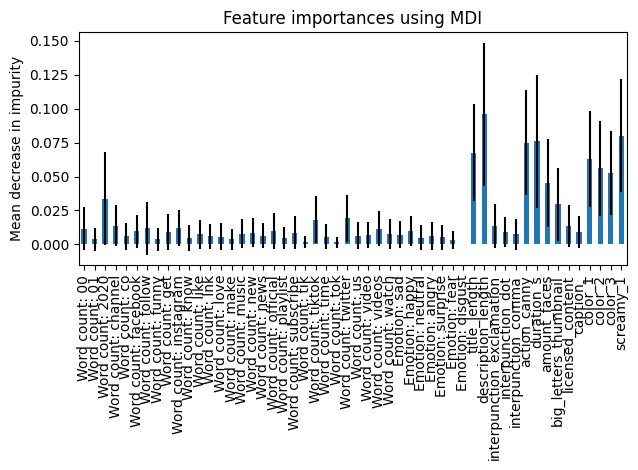

In [13]:
forest_importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
forest_importances = pd.Series(rfc.feature_importances_, index=column_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression()
reg.fit(Xtrain, ytrain)

pred = reg.predict(Xtest)
print('Accuracy:, ', accuracy_score(ytest, pred), ', F1: ', f1_score(ytest, pred), '\n', confusion_matrix(ytest, pred))

dict(zip((column_names), [c for c in reg.coef_[0]]))

Accuracy:,  0.7008032128514057 , F1:  0.7638668779714739 
 [[108  90]
 [ 59 241]]


{'Word count: 00': -0.30188227929679196,
 'Word count: 01': -0.5634530360516663,
 'Word count: 2020': -1.0717399780890182,
 'Word count: channel': 0.9474055064331082,
 'Word count: co': 0.1859340920881752,
 'Word count: facebook': -0.5119520858701676,
 'Word count: follow': 0.047032610270029716,
 'Word count: funny': -0.6813055594894754,
 'Word count: get': 0.3685417671764775,
 'Word count: instagram': -0.2087248611766257,
 'Word count: know': 0.09582789333709615,
 'Word count: like': -0.28649361225936737,
 'Word count: lnk': 0.6069800084263324,
 'Word count: love': 0.21064614249595806,
 'Word count: make': -0.07912031155688008,
 'Word count: music': -0.46728380238823797,
 'Word count: new': 0.3992855015303968,
 'Word count: news': 0.25803600588363,
 'Word count: official': -0.0971001661741866,
 'Word count: playlist': -0.7198779222323352,
 'Word count: subscribe': -0.1312559968339203,
 'Word count: tik': -0.1847293234065639,
 'Word count: tiktok': -0.7237639631192283,
 'Word count: ti

Zgodnie z oczekiwaniami, regresja logistyczna daje znacznie gorsze wyniki w klasyfikacji, ponieważ operuje bezkontekstowo na każdym z atrybutów z osobna. Mimo to, jej wykorzystanie doda pewne interpretowalne dane uzupełniające do zebranej do tej pory wiedzy - regresja logistyczna może w wygodny sposób oceniać korelację z przynależnością do klasy trending. Wagi poszczególnych cech mogą być cenną wskazówką, zwłaszcza że wykorzystywany zbiór danych nie zawiera najsilniej skorelowanych atrybutów (w takim przypadku, ich dane mogłyby być w znacznym stopniu przypadkowe, a tylko ich suma wynikałaby z wartości etykiet).

Żeby uniknąć zbędnych, niezbadanych wcześniej korelacji z wystąpieniami konkretnych słów, wywołajmy model bez opisujących ich atrybutów.

In [24]:
reg2 = LogisticRegression()
print([colname for colname in Xdf if not 'Word count' in colname])
new_Xtrain = Xtrain[[colname for colname in Xdf if not 'Word count' in colname]]
new_Xtest = Xtest[[colname for colname in Xdf if not 'Word count' in colname]]
reg.fit(new_Xtrain, ytrain)


pred = reg.predict(new_Xtest)
print('Accuracy:, ', accuracy_score(ytest, pred), ', F1: ', f1_score(ytest, pred), '\n', confusion_matrix(ytest, pred))

dict(zip((list(new_Xtrain)), [c for c in reg.coef_[0]]))

['Emotion: sad', 'Emotion: happy', 'Emotion: neutral', 'Emotion: angry', 'Emotion: surprise', 'Emotion: fear', 'Emotion: disgust', 'title_length', 'description_length', 'interpunction_exclamation', 'interpunction_dot', 'interpunction_comma', 'action_canny', 'duration_s', 'amount_faces', 'big_letters_thumbnail', 'licensed_content', 'caption_', 'color_1', 'color_2', 'color_3', 'screamy_1']
['Emotion: sad', 'Emotion: happy', 'Emotion: neutral', 'Emotion: angry', 'Emotion: surprise', 'Emotion: fear', 'Emotion: disgust', 'title_length', 'description_length', 'interpunction_exclamation', 'interpunction_dot', 'interpunction_comma', 'action_canny', 'duration_s', 'amount_faces', 'big_letters_thumbnail', 'licensed_content', 'caption_', 'color_1', 'color_2', 'color_3', 'screamy_1']
Accuracy:,  0.6104417670682731 , F1:  0.7130177514792898 
 [[ 63 135]
 [ 59 241]]


{'Emotion: sad': 0.34336409277754304,
 'Emotion: happy': 0.7470059520087701,
 'Emotion: neutral': 0.6663775274816728,
 'Emotion: angry': 0.9314109998784629,
 'Emotion: surprise': 0.7995636030823171,
 'Emotion: fear': 0.49722205227104727,
 'Emotion: disgust': 0.0,
 'title_length': -0.43975320253661354,
 'description_length': -0.6035358489824958,
 'interpunction_exclamation': 0.4809633322237872,
 'interpunction_dot': 0.27382157747507224,
 'interpunction_comma': -0.27030726427928514,
 'action_canny': -0.6472640359452241,
 'duration_s': -0.724182264824758,
 'amount_faces': 0.1618400457492195,
 'big_letters_thumbnail': 0.4025531156308448,
 'licensed_content': 0.2693718829009444,
 'caption_': 0.3911425680216929,
 'color_1': -0.36790311113360535,
 'color_2': 0.024121248204439973,
 'color_3': -0.03563653747234385,
 'screamy_1': 0.1577163226497477}

Na podstawie informacji o tym, jakie dane wykorzystuje drzewo decyzyjne i szybkiego potwierdzenia, jaki znak posiadają ich wagi w modelu regresji logistycznej, można ocenić, które z mają dominujący wpływ na szanse dostania się do zakładki trending oraz czy należy celować w ich wysokie czy niskie wartości.

Gdy liczba tagów znajduje się wśród danych uczących, staje się dominującym predyktorem dla lasu losowego. Można przypuszczać, że ma ona znaczny wpływ na szanse filmu do trafienia do sekcji trending (lub samego zdobycia popularności, które jest najprawdopodobniej warunkiem koniecznym). Można wręcz powiedzieć, że nieumieszczenie co najmniej kilku tagów jest kardynalnym błędem dla youtubera, którego ci bardziej doświadczeni i popularni nie z reguły nie popełniają - różnica w rozkładach tego parametru dla obu zbiorów jest ogromna.

Rozkład długości filmów z trending różni się w stosunku do filmów z non-trending. Z reguły, filmy z trending są krótsze.

"Clickbaity" w postaci wielkich liter czy wykrzykników działają. 

Wiele przecinków przeważnie przeszkadza w dostaniu się do trending. Być może są one charakterystyczne, dla długich, deskryptywnych tytułów, które jednak nie przyciągają aż tak bardzo uwagi.

Każda z wykrywanych emocji (poza odrazą) ma dodatnią wagę w modelu. Nie sygnalizuje to żadnego błędu w klasyfikacji, gdyż większość filmów nie miała przypisanej etykiety emocji.

W modelu lasu losowego, duże znaczenie miało wiele atrybutów związanych z miniaturkami filmów. Dobry thumbnail powinien zawierać dużo "akcji" (szacowanej na podstawie ilości konturów w obrazie), może też mieć "krzykliwy" charakter. Średnio, thumbnaile z sekcji trending cechują się również inną paletą barw - najprawdopodobniej rzucająca się w oczy miniaturka pomaga filmowi odnieść sukces. Jednakże, duża ilość "akcji" opisanej jako ilość konturów przeszkadza w dostaniu się do trending. Zdaje się więc, że mimo wszystko miniaturka powinna cechować się względną prostotą, a nie zawierać wiele informacji.

Podsumowując, wydaje się spójną tendencją w tytułach czy miniaturkach - dobrze jest zasypywać użytkownika emocjami, a nie informacjami.